In [796]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [797]:
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_trattati.csv' # cleaned data
df = pd.read_csv(file_path)
df['datadate'] = pd.to_datetime(df['datadate'])
df['datadate'] = df['datadate'] + pd.offsets.QuarterEnd(0)

df = df.dropna(subset=['relative_quarterly_return'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14322 entries, 1 to 15338
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           14322 non-null  int64         
 1   datadate                        14322 non-null  datetime64[ns]
 2   tic                             14322 non-null  object        
 3   actq                            14322 non-null  float64       
 4   ancq                            14322 non-null  float64       
 5   epsfxq                          14302 non-null  float64       
 6   lctq                            14322 non-null  float64       
 7   ltq                             14322 non-null  float64       
 8   revtq                           14322 non-null  float64       
 9   capxy                           13783 non-null  float64       
 10  roa                             14289 non-null  float64       
 11  ro

In [798]:
drop_features = ['capxy', 'cfm', 'PEG_trailing', 'de_ratio', 'divyield']
df = df.drop(drop_features, 1)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 32 to 15337
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non-null  float64       
 11  p

In [799]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 80
['AAPL' 'ABT' 'ADBE' 'ADM' 'AMD' 'AMGN' 'AMT' 'AMZN' 'APD' 'BA' 'BAX'
 'BMY' 'CAT' 'CL' 'CME' 'COP' 'COST' 'CSCO' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL'
 'EQIX' 'EXC' 'EXPE' 'F' 'FDX' 'FIS' 'GE' 'GOOGL' 'HCA' 'HD' 'IBM' 'INTC'
 'JBL' 'JNJ' 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM'
 'MRK' 'MSFT' 'MU' 'NFLX' 'NKE' 'NOC' 'NVDA' 'OXY' 'PFE' 'PG' 'PPL' 'PYPL'
 'QCOM' 'REGN' 'RJF' 'RTX' 'SBUX' 'SPGI' 'STZ' 'T' 'TGT' 'TMO' 'TSLA'
 'TSN' 'UNH' 'UPS' 'V' 'VZ' 'WBA' 'WDC' 'WMT' 'XOM' 'ZTS']


In [800]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.info()

Number of unique gvkeys: 80
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 172 to 3737
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   gvkey                           11212 non-null  int64         
 1   datadate                        11212 non-null  datetime64[ns]
 2   tic                             11212 non-null  object        
 3   actq                            11212 non-null  float64       
 4   ancq                            11212 non-null  float64       
 5   epsfxq                          11212 non-null  float64       
 6   lctq                            11212 non-null  float64       
 7   ltq                             11212 non-null  float64       
 8   revtq                           11212 non-null  float64       
 9   roa                             11212 non-null  float64       
 10  roe                             11212 non

In [801]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

df = df[~df['tic'].isin(tickers_to_drop)]

In [802]:
train_start_date = '1970-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2023-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_prccq_change'], ascending=[True, False])
test_df.head(10)


,gvkey,datadate,tic,actq,ancq,epsfxq,lctq,ltq,revtq,roa,...,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return,spindx,spindx_change,next_spindx_change,prccq,prccq_change,next_prccq_change
1253,1161,2013-03-31,AMD,0.032230,-0.159078,-0.698413,-0.054402,-0.023108,-0.058009,0.023,...,-0.008020,1.083812,-0.032845,0.566207,1562.17,0.095345,0.033793,2.550,0.062500,0.600000
10115,7343,2013-03-31,MU,0.009219,-0.023309,0.037037,-0.009822,0.012073,0.133043,0.107,...,-0.014717,0.297872,0.334470,0.318003,1514.68,0.069553,0.076623,8.375,0.404023,0.394627
11978,23812,2013-03-31,REGN,0.083838,0.107948,-0.779412,0.206017,0.041366,0.060448,0.383,...,-0.205994,0.289679,-0.064171,0.241016,1562.17,0.095345,0.033793,176.403,0.031174,0.274808
3228,149070,2013-03-31,CME,0.410638,-0.000707,0.420000,0.547441,0.197396,0.087305,0.049,...,-0.004367,0.134783,0.116615,0.202977,1562.17,0.095345,0.033793,61.410,0.211960,0.236769
14621,11399,2013-03-31,WDC,0.022997,-0.024726,0.176471,-0.030066,-0.031327,-0.015690,0.266,...,0.087776,0.291424,0.088228,0.200846,1562.17,0.095345,0.033793,50.290,0.183573,0.234639
9959,12141,2013-03-31,MSFT,0.044098,0.037638,-0.052632,0.000595,0.023348,-0.045069,0.256,...,0.002184,0.186091,-0.024386,0.173863,1562.17,0.095345,0.033793,28.605,0.070959,0.207656
13004,2710,2013-03-31,STZ,-0.003789,-0.115575,-0.258621,-0.139502,-0.138732,-0.092581,0.091,...,0.359567,0.514735,0.163446,0.121613,1514.68,0.069553,0.076623,44.240,0.232999,0.198237
2121,2285,2013-03-31,BA,0.038057,-0.019945,0.125000,0.015206,-0.000506,-0.152856,0.094,...,-0.008634,0.015841,0.043854,0.159451,1562.17,0.095345,0.033793,85.850,0.139199,0.193244
10580,7985,2013-03-31,NOC,-0.065062,-0.004573,-0.051402,-0.082728,-0.034294,-0.057443,0.139,...,0.002886,0.249847,-0.057316,0.146535,1562.17,0.095345,0.033793,70.150,0.038029,0.180328
13375,3813,2013-03-31,TGT,-0.113923,0.022230,0.531250,-0.106818,-0.048816,0.342430,0.155,...,-0.026667,0.125000,-0.113256,0.101628,1498.11,0.060864,0.066390,60.410,-0.052392,0.168019


In [803]:
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

drop_cols = ['gvkey', 'datadate', 'tic', 'spindx', 'spindx_change', 'next_spindx_change', 'prccq', 'prccq_change', 'next_prccq_change']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

train_df.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return,next_relative_quarterly_return
172,0.0,0.0,-0.115385,0.0,0.0,-0.016251,0.224,0.556,25.408,34.228,...,0.0,0.000000,0.000000,0.000000,-0.295597,0.0,0.0,-0.177037,-0.016088,0.028255
15082,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,11.749,6.020,...,0.0,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479,0.144996
5213,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,9.079,3.284,...,0.0,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857,0.147681
1734,0.0,0.0,0.181818,0.0,0.0,0.089057,0.146,0.097,15.323,14.417,...,0.0,0.000000,0.000000,-0.016949,-0.363201,0.0,0.0,-0.095171,0.130826,0.071186
4912,0.0,0.0,0.304444,0.0,0.0,0.135055,0.112,0.110,11.028,5.864,...,0.0,0.000000,-0.011628,-0.013699,0.000000,0.0,0.0,-0.114448,0.036812,-0.002057


In [804]:
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return',], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return',], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return',], 1)

X_train.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
172,0.0,0.0,-0.115385,0.0,0.0,-0.016251,0.224,0.556,25.408,34.228,...,0.000000,0.0,0.000000,0.000000,0.000000,-0.295597,0.0,0.0,-0.177037,-0.016088
15082,0.0,0.0,-0.013423,0.0,0.0,0.036061,0.170,0.032,11.749,6.020,...,-0.000895,0.0,-0.028041,-0.106383,-0.108434,0.237403,0.0,0.0,0.050788,-0.046479
5213,0.0,0.0,-0.135338,0.0,0.0,-0.172254,0.211,0.034,9.079,3.284,...,0.371212,0.0,0.354212,-0.326087,-0.054054,0.148148,0.0,0.0,-0.005464,0.138857
1734,0.0,0.0,0.181818,0.0,0.0,0.089057,0.146,0.097,15.323,14.417,...,0.000000,0.0,0.000000,0.000000,-0.016949,-0.363201,0.0,0.0,-0.095171,0.130826
4912,0.0,0.0,0.304444,0.0,0.0,0.135055,0.112,0.110,11.028,5.864,...,0.000000,0.0,0.000000,-0.011628,-0.013699,0.000000,0.0,0.0,-0.114448,0.036812


In [805]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,actq,ancq,epsfxq,lctq,ltq,revtq,roa,roe,pe_inc,pcf,...,debt_ebitda_change,gpm_change,evm_change,cfm_change,npm_change,PEG_trailing_change,de_ratio_change,curr_ratio_change,ptb_change,relative_quarterly_return
0,0.15915,0.15647,0.600363,0.14011,0.103656,0.085120,0.812405,0.307713,0.563323,0.503678,...,0.305676,0.28277,0.505650,0.543478,0.892899,0.114620,0.075733,0.263092,0.022231,0.117021
1,0.15915,0.15647,0.600801,0.14011,0.103656,0.089930,0.796067,0.301351,0.555988,0.461638,...,0.305671,0.28277,0.505401,0.541744,0.892514,0.114802,0.075733,0.263092,0.029147,0.112010
2,0.15915,0.15647,0.600278,0.14011,0.103656,0.070774,0.808472,0.301376,0.554554,0.457561,...,0.307639,0.28277,0.508806,0.538162,0.892708,0.114771,0.075733,0.263092,0.027439,0.142569
3,0.15915,0.15647,0.601639,0.14011,0.103656,0.094803,0.788805,0.302140,0.557907,0.474153,...,0.305676,0.28277,0.505650,0.543478,0.892839,0.114597,0.075733,0.263092,0.024716,0.141245
4,0.15915,0.15647,0.602165,0.14011,0.103656,0.099033,0.778517,0.302298,0.555600,0.461406,...,0.305676,0.28277,0.505650,0.543289,0.892851,0.114721,0.075733,0.263092,0.024131,0.125743


In [806]:
'''

model = xgb.XGBRanker(
    objective="rank:pairwise",  
    eval_metric="ndcg",
    learning_rate=0.05,
    max_depth=8,
    gamma=0.1,
    random_state=42,
    n_estimators=300
)

# Fit model with `group`
model.fit(X_train, y_train, group=train_group)

'''

'\n\nmodel = xgb.XGBRanker(\n    objective="rank:pairwise",  \n    eval_metric="ndcg",\n    learning_rate=0.05,\n    max_depth=8,\n    gamma=0.1,\n    random_state=42,\n    n_estimators=300\n)\n\n# Fit model with `group`\nmodel.fit(X_train, y_train, group=train_group)\n\n'

In [807]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.05],
    'max_depth': [8],
    'gamma': [0.1],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[02:57:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[02:57:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[02:57:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[02:57:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[02:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.2642603156830485
CPU times: user 24.9 s, sys: 1.32 s, total: 26.2 s
Wall time: 6.2 s


In [808]:

%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)



CPU times: user 6.77 s, sys: 491 ms, total: 7.26 s
Wall time: 4.89 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

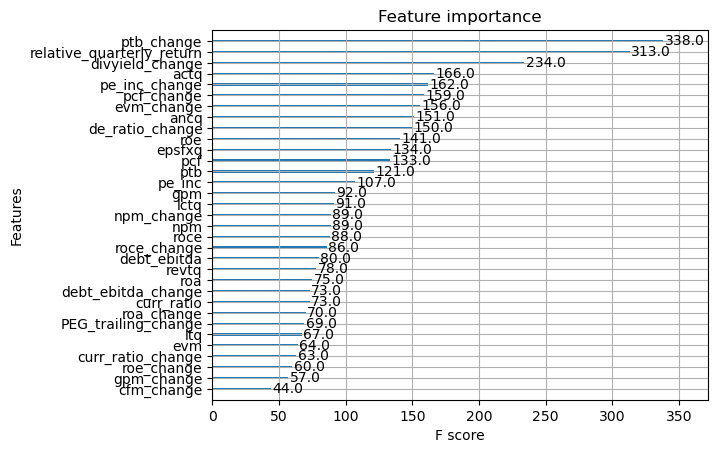

In [809]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]


In [810]:
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(classification_report(y_train_binary, y_train_pred_binary))



              precision    recall  f1-score   support

           0       0.73      0.67      0.70      3460
           1       0.73      0.78      0.76      3936

    accuracy                           0.73      7396
   macro avg       0.73      0.73      0.73      7396
weighted avg       0.73      0.73      0.73      7396



In [811]:
results['y_pred'] = y_test_pred
results = results.sort_values(by=['datadate', 'next_prccq_change'], ascending=[True, False])

results.head(10)



,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred
1253,2013-03-31,AMD,0.600000,0.566207,0.424789
10115,2013-03-31,MU,0.394627,0.318003,0.083668
11978,2013-03-31,REGN,0.274808,0.241016,0.244794
3228,2013-03-31,CME,0.236769,0.202977,0.080938
14621,2013-03-31,WDC,0.234639,0.200846,0.111080
9959,2013-03-31,MSFT,0.207656,0.173863,0.152188
13004,2013-03-31,STZ,0.198237,0.121613,0.278554
2121,2013-03-31,BA,0.193244,0.159451,0.079390
10580,2013-03-31,NOC,0.180328,0.146535,0.085428
13375,2013-03-31,TGT,0.168019,0.101628,0.090245


In [812]:
# Group by 'datadate' and calculate the count of rows and the mean of 'next_prccq_change'
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()


# Add a 'top_10' column that contains the average of the top 10 highest 'y_pred' for each quarter
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(10, 'y_pred')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(10, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'y_pred')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(10, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)

# Show the first few rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,63,0.065437,0.212393,0.268833,-0.036217,-0.084238
1,2013-06-30,64,0.059808,0.136871,0.230842,-0.022282,-0.061988
2,2013-09-30,66,0.110123,0.223018,0.314411,-0.026169,-0.058148
3,2013-12-31,66,0.032754,0.120628,0.183728,-0.004106,-0.082451
4,2014-03-31,66,0.039382,0.083766,0.158701,0.007800,-0.061300
5,2014-06-30,67,0.022670,0.102033,0.167058,-0.057136,-0.099601
6,2014-09-30,65,0.054048,0.173410,0.196296,-0.048558,-0.109057
7,2014-12-31,64,0.027150,0.126319,0.177872,-0.053434,-0.122243
8,2015-03-31,65,0.009599,0.111943,0.175274,-0.071232,-0.111613
9,2015-06-30,63,-0.056546,0.068758,0.096890,-0.182313,-0.220885


In [813]:
for portfolio in ['baseline', 'top_10', 'bottom_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03360167684373077
Sharpe Ratio of the baseline portfolio: 0.14378314191983466

Mean quarterly return of the top_10 portfolio: 0.15169882681678454
Sharpe Ratio of the top_10 portfolio: 1.6693187248011534

Mean quarterly return of the bottom_10 portfolio: -0.07486402792603356
Sharpe Ratio of the bottom_10 portfolio: -1.300403629424268



In [814]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_cum_return'] = (1 + df_avg['top_10']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_value'] = initial_investment * df_avg['top_10_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add top_10 portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_value'],
                         mode='lines', name='Top 10 Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


In [815]:
train_df = train_df[important_features + ['next_relative_quarterly_return']]
valid_df = valid_df[important_features + ['next_relative_quarterly_return']]
test_df  = test_df[important_features + ['next_relative_quarterly_return']]

y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(['next_relative_quarterly_return'], 1)

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(['next_relative_quarterly_return'], 1)

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(['next_relative_quarterly_return'], 1)

# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled.head()

,ptb_change,relative_quarterly_return,divyield_change,actq,pe_inc_change
0,0.022231,0.117021,0.166364,0.15915,0.548851
1,0.029147,0.112010,0.128508,0.15915,0.549597
2,0.027439,0.142569,0.136216,0.15915,0.550186
3,0.024716,0.141245,0.149920,0.15915,0.549042
4,0.024131,0.125743,0.153609,0.15915,0.545904


In [816]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 8,
    'learning_rate': 0.05,
    'n_estimators': 300,
    'gamma': 0.1,
    'random_state': 42
}
eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(**params)
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [817]:
# Predictions
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)
y_test_pred = model.predict(X_test_scaled)

# Classifier
y_train_pred_binary = (y_train_pred >= 0).astype(int)
y_valid_pred_binary = (y_valid_pred >= 0).astype(int)
y_test_pred_binary = (y_test_pred >= 0).astype(int)

y_train_binary = (y_train >= 0).astype(int)
y_valid_binary = (y_valid >= 0).astype(int)
y_test_binary = (y_test >= 0).astype(int)

print(y_test_pred)

print(classification_report(y_test_binary, y_test_pred_binary))


[ 4.1838512e-01  1.1871296e-01  2.1418741e-01 ...  3.2545775e-04
  1.0346082e-02 -2.2540718e-02]
              precision    recall  f1-score   support

           0       0.74      0.58      0.65      1373
           1       0.65      0.79      0.71      1349

    accuracy                           0.69      2722
   macro avg       0.69      0.69      0.68      2722
weighted avg       0.69      0.69      0.68      2722



In [818]:
results['y_pred_sim'] = y_test_pred
results = results.sort_values(by=['datadate', 'y_pred_sim'])

results.tail(10)

,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred,y_pred_sim
12019,2023-06-30,REGN,0.145322,0.181798,0.070985,0.081378
13812,2023-06-30,TSN,-0.010776,0.025700,0.059037,0.093184
8145,2023-06-30,LLY,0.145315,0.181791,0.104375,0.121714
14662,2023-06-30,WDC,0.203006,0.239481,0.085986,0.122554
2972,2023-06-30,CAT,0.109531,0.146006,0.177917,0.126662
10718,2023-06-30,NVDA,0.683989,0.582956,0.163421,0.182804
532,2023-06-30,ADBE,0.338807,0.260375,0.186654,0.190469
6886,2023-06-30,JBL,0.278150,0.199719,0.201381,0.221455
3484,2023-06-30,COP,0.156259,0.192735,0.183553,0.230979
9487,2023-06-30,MMM,-0.064642,-0.028166,0.167308,0.293874


In [819]:
# Group by 'datadate' and calculate the count of rows and the mean of 'next_prccq_change'
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()


# Add a 'top_10' column that contains the average of the top 10 highest 'y_pred' for each quarter
df_avg['top_10'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(5, 'y_pred_sim')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nlargest(5, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(5, 'y_pred_sim')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)


df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda x: x.nsmallest(5, 'next_prccq_change')['next_prccq_change'].mean()
).reset_index(level=0, drop=True)

# Show the first few rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10,top_10_ideal,bottom_10,bottom_10_ideal
0,2013-03-31,63,0.065437,0.303068,0.348169,-0.024799,-0.115386
1,2013-06-30,64,0.059808,0.115898,0.297694,-0.051979,-0.077451
2,2013-09-30,66,0.110123,0.224949,0.362922,-0.019769,-0.103400
3,2013-12-31,66,0.032754,0.078019,0.231314,-0.048927,-0.104605
4,2014-03-31,66,0.039382,0.091153,0.205114,0.041314,-0.081620
5,2014-06-30,67,0.022670,0.170096,0.205062,-0.061809,-0.125342
6,2014-09-30,65,0.054048,0.199859,0.227675,-0.119781,-0.160392
7,2014-12-31,64,0.027150,0.085050,0.202082,-0.098981,-0.143343
8,2015-03-31,65,0.009599,0.154369,0.241950,-0.115747,-0.137630
9,2015-06-30,63,-0.056546,0.079047,0.127415,-0.189858,-0.271339


In [820]:
for portfolio in ['baseline', 'top_10']:

    mean_return = df_avg[portfolio].mean()

    # Calculate the standard deviation of the returns of the top 10 portfolio
    std_return = df_avg[portfolio].std()

    # Assuming the risk-free rate is 0 (if you have a specific risk-free rate, replace 0 with that value)
    risk_free_rate = 0.025

    # Calculate the Sharpe ratio
    sharpe_ratio = (mean_return - risk_free_rate) / std_return

    # Print the Sharpe ratio
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return}")
    print(f"Sharpe Ratio of the {portfolio} portfolio: {sharpe_ratio}")
    print("")

Mean quarterly return of the baseline portfolio: 0.03360167684373077
Sharpe Ratio of the baseline portfolio: 0.14378314191983468

Mean quarterly return of the top_10 portfolio: 0.1852543262624191
Sharpe Ratio of the top_10 portfolio: 1.6649272420223222

